# Lesson 28: TensorFlow/Keras classification activity

## Notebook set up
### Imports

In [26]:
# Standard library imports
import itertools

from pathlib import Path
from shutil import rmtree
from typing import Tuple, Optional

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

### GPU configuration

In [2]:
# Configure GPU settings
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Use only GPU 0
        tf.config.set_visible_devices(gpus[0], 'GPU')

        # Enable memory growth
        tf.config.experimental.set_memory_growth(gpus[0], True)

        print(f'Using GPU: {gpus[0]}')
        print('Memory growth enabled')

    except RuntimeError as e:
        print(e)

# Trigger one-time XLA compilation message so we don't have to look at it later
@tf.function(jit_compile=True)
def simple_xla_op():
    return tf.add(tf.constant(1.0), tf.constant(2.0))

_ = simple_xla_op()

Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Memory growth enabled


I0000 00:00:1769469132.564580  154845 service.cc:145] XLA service 0x559405517050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769469132.564619  154845 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1769469132.600277  154845 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


### Global TensorFlow training configuration

In [3]:
# Remove and recreate logs directory to clear any old TensorBoard logs
log_dir = ('../logs')
rmtree(log_dir, ignore_errors=True)
Path(log_dir).mkdir(parents=True, exist_ok=True)

# Set verbosity for wherever it's accepted
verbose = 0

# Fix TensorFlow random state for reproducibility
tf.random.set_seed(315)

## 1. Data preparation

### 1.1. Load occupancy data

In [4]:
occupancy_df = pd.read_csv('https://gperdrizet.github.io/FSA_devops/assets/data/unit4/occupancy_data.csv')
occupancy_df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
1,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
2,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
3,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
4,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [5]:
occupancy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20560 entries, 0 to 20559
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           20560 non-null  object 
 1   Temperature    20560 non-null  float64
 2   Humidity       20560 non-null  float64
 3   Light          20560 non-null  float64
 4   CO2            20560 non-null  float64
 5   HumidityRatio  20560 non-null  float64
 6   Occupancy      20560 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 1.1+ MB


In [6]:
label = 'Occupancy'
features = ['Temperature','Humidity','Light','CO2','HumidityRatio']

### 1.2. Train test split

In [7]:
training_df, testing_df = train_test_split(occupancy_df, random_state=315)

### 1.3. Standard scale

In [8]:
feature_scaler = StandardScaler()
feature_scaler.fit(training_df[features])

training_df[features] = feature_scaler.transform(training_df[features])
testing_df[features] = feature_scaler.transform(testing_df[features])

## 2. Logistic regression baseline

### 2.1. Fit

In [9]:
logistic_model = LogisticRegression(n_jobs=-1, random_state=315)
fit_result = logistic_model.fit(training_df[features], training_df[label])

### 2.2. Test set evaluation

In [10]:
logistic_predictions = logistic_model.predict(testing_df[features])
logistic_accuracy = accuracy_score(testing_df[label], logistic_predictions)
print(f'Logistic regression accuracy on test set: {logistic_accuracy:.4f}')

Logistic regression accuracy on test set: 0.9907


## 3. DNN model

### 3.1. Compute class weights

In [11]:
# Compute class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(training_df[label]),
    y=training_df[label]
)

class_weight_dict = dict(enumerate(class_weights))
print(f'Class weights: {class_weight_dict}')

Class weights: {0: 0.6505231184610193, 1: 2.1608744394618835}


### 3.2. Callback constructor function

In [12]:
def make_callbacks(
    learning_rate: float,
    batch_size: int,
    patience: int = 10,
) -> Tuple[keras.callbacks.EarlyStopping, keras.callbacks.TensorBoard]:
    '''Create EarlyStopping and TensorBoard callbacks.'''

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        verbose=verbose
    )

    run_log_dir = f'{log_dir}/lr_{learning_rate}_bs_{batch_size}'

    Path(run_log_dir).mkdir(parents=True, exist_ok=True)

    tensorboard_callback = keras.callbacks.TensorBoard(
        log_dir=run_log_dir,
        histogram_freq=1,
        write_graph=False
    )

    return early_stopping, tensorboard_callback

### 3.3. Model constructor function

In [13]:
def build_model(learning_rate: float=0.01) -> keras.Sequential:
    '''Builds and compiles the Keras Sequential model.'''

    model = keras.Sequential([
        layers.Input(shape=(5,)),
        layers.Dense(16, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

### 3.4. Model training function

In [27]:
def train_model(
    model: keras.Sequential,
    epochs: int=200,
    batch_size: int=128,
    validation_split: Optional[float]=0.2,
    callbacks: Tuple[keras.callbacks.EarlyStopping, keras.callbacks.TensorBoard]=None
) -> Tuple[keras.Sequential, keras.callbacks.History]:
    '''Trains the Keras Sequential model. Returns the training history.'''

    history = model.fit(
        training_df[features],
        training_df[label],
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        class_weight=class_weight_dict,
        callbacks=callbacks,
        verbose=verbose
    )

    return model, history

### 3.5. Optimize batch size and learning rate

In [15]:
%%time

batch_sizes = [256, 512, 1024]
learning_rates = [1e-6, 1e-5, 1e-4]

for batch_size, learning_rate in itertools.product(batch_sizes, learning_rates):

    print(f'Batch size: {batch_size}, learning rate: {learning_rate}...', end='\t')

    # Set-up callback for this run
    callbacks = make_callbacks(learning_rate=learning_rate, batch_size=batch_size)

    # Build and train the model
    model = build_model(learning_rate=learning_rate)
    model, history = train_model(model, batch_size=batch_size, callbacks=callbacks)

    print(f"final val loss: {history.history['val_loss'][-1]:.4f}, ", end=' ') 
    print(f"final val accuracy: {history.history['val_accuracy'][-1]*100:.2f}%")

print()

Batch size: 256, learning rate: 1e-06...	final val loss: 0.6463,  final val accuracy: 80.38%
Batch size: 256, learning rate: 1e-05...	final val loss: 0.1256,  final val accuracy: 98.05%
Batch size: 256, learning rate: 0.0001...	final val loss: 0.0427,  final val accuracy: 98.90%
Batch size: 512, learning rate: 1e-06...	final val loss: 0.7368,  final val accuracy: 61.38%
Batch size: 512, learning rate: 1e-05...	final val loss: 0.4012,  final val accuracy: 96.34%
Batch size: 512, learning rate: 0.0001...	final val loss: 0.0446,  final val accuracy: 98.80%
Batch size: 1024, learning rate: 1e-06...	final val loss: 0.6840,  final val accuracy: 74.81%
Batch size: 1024, learning rate: 1e-05...	final val loss: 0.6027,  final val accuracy: 81.81%
Batch size: 1024, learning rate: 0.0001...	final val loss: 0.0476,  final val accuracy: 98.74%
CPU times: user 10min 47s, sys: 33.1 s, total: 11min 20s
Wall time: 8min 52s


Based on the final loss & accuracy and the TensorBoard learning curves the best settings are:

- Batch size: 256
- Learning rate: 0.0001

In [28]:
batch_size = 256
learning_rate = 0.0001

### 3.6. Re-train with optimized hyperparameters

In [33]:
callbacks = make_callbacks(learning_rate=learning_rate, batch_size=batch_size)
model = build_model(learning_rate=learning_rate)
model, history = train_model(model, batch_size=batch_size, callbacks=callbacks)

### 3.7. Learning curves

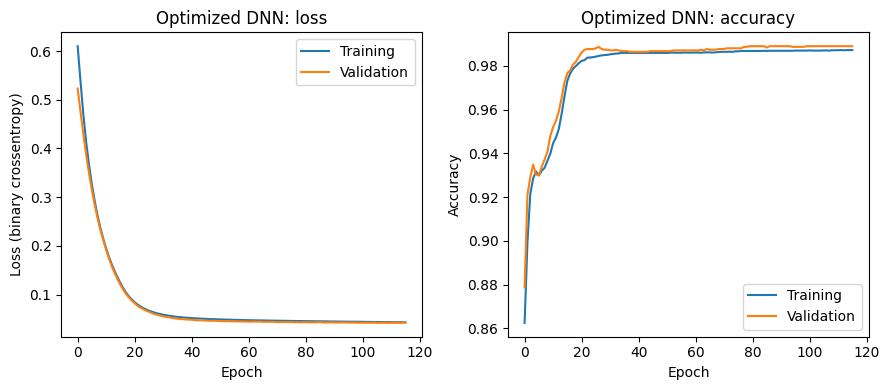

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

axes[0].set_title('Optimized DNN: loss')
axes[0].plot(history.history['loss'], label='Training')
axes[0].plot(history.history['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (binary crossentropy)')
axes[0].legend(loc='best')

axes[1].set_title('Optimized DNN: accuracy')
axes[1].plot(history.history['accuracy'], label='Training')
axes[1].plot(history.history['val_accuracy'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend(loc='best')

plt.tight_layout()
plt.show()

### 3.8. Test set evaluation

In [35]:
sequential_probs = model.predict(testing_df[features], verbose=0).flatten()
sequential_predictions = (sequential_probs >= 0.5).astype(int)
sequential_accuracy = accuracy_score(testing_df[label], sequential_predictions)

print(f'Optimized DNN model accuracy on test set: {sequential_accuracy:.4f}')

Optimized DNN model accuracy on test set: 0.9899


### 3.9. Performance analysis

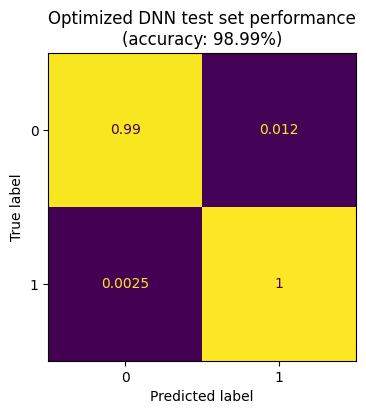

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

ax.set_title(f'Optimized DNN test set performance\n(accuracy: {sequential_accuracy:.2%})')

disp = ConfusionMatrixDisplay.from_predictions(
    testing_df[label],
    sequential_predictions,
    normalize='true',
    ax=ax,
    colorbar=False
)

## 4. Model comparison

In [37]:
print(f'Logistic regression accuracy on test set: {logistic_accuracy:.4f}')
print(f'Optimized DNN model accuracy on test set: {sequential_accuracy:.4f}')

Logistic regression accuracy on test set: 0.9907
Optimized DNN model accuracy on test set: 0.9899


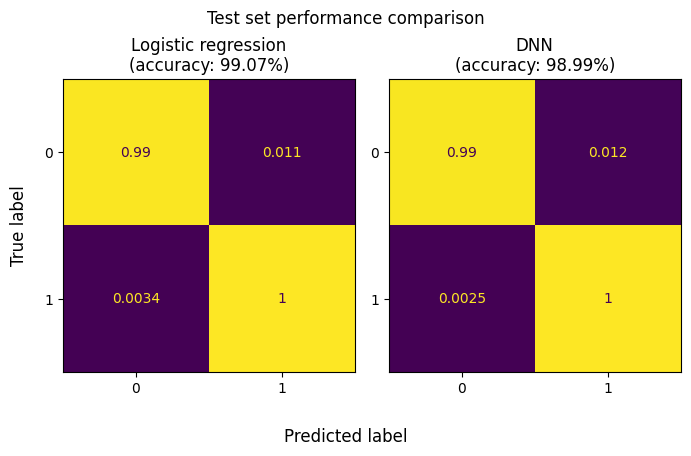

In [38]:
# Compare confusion matrices for logistic regression and DNN
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 4.5))

fig.suptitle('Test set performance comparison')
fig.supxlabel('Predicted label')
fig.supylabel('True label')

# Confusion matrix for logistic regression
axes[0].set_title(f'Logistic regression\n(accuracy: {logistic_accuracy:.2%})')

disp_logistic = ConfusionMatrixDisplay.from_predictions(
    testing_df[label],
    logistic_predictions,
    normalize='true',
    ax=axes[0],
    colorbar=False
)

axes[0].set_xlabel('')
axes[0].set_ylabel('')

# Confusion matrix for DNN model
axes[1].set_title(f'DNN\n(accuracy: {sequential_accuracy:.2%})')

disp_sequential = ConfusionMatrixDisplay.from_predictions(
    testing_df[label],
    sequential_predictions,
    normalize='true',
    ax=axes[1],
    colorbar=False
)

axes[1].set_xlabel('')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

## 5. Final training run

In [40]:
# Combine training and testing datasets for final training
combined_df = pd.concat([training_df, testing_df], ignore_index=True)

# Build final model with optimized hyperparameters
final_model = build_model(learning_rate=learning_rate)

# Train on combined dataset (no validation split for final run)
final_history = final_model.fit(
    combined_df[features],
    combined_df[label],
    epochs=200,
    batch_size=batch_size,
    class_weight=class_weight_dict,
    verbose=verbose
)

print(f"Final training accuracy: {final_history.history['accuracy'][-1]*100:.2f}%")
print(f"Final training loss: {final_history.history['loss'][-1]:.4f}")

Final training accuracy: 98.90%
Final training loss: 0.0366


In [ ]:
# Save the final model
Path('../models').mkdir(parents=True, exist_ok=True)
final_model.save('../models/optimized_occupancy_dnn_model.keras')

INFO:tensorflow:Assets written to: ../models/optimized_occupancy_dnn_model/assets


INFO:tensorflow:Assets written to: ../models/optimized_occupancy_dnn_model/assets
